In [1]:
import treecorr
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

# these are the GLASS imports: cosmology and everything in the glass namespace
from astropy.io import fits
import healpy as hp
# also needs camb itself to get the parameter object

import sys
sys.path.append('../src')
import glass_mock
from importlib import reload
reload(glass_mock)
import generate_mocksys
reload(generate_mocksys)

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

# Define some simple selection functions

In [2]:
p3 = np.poly1d([0.3, 0.7])
p2 = np.poly1d([-0.2, 1])
p1_tri = generate_mocksys.trig_func(0.05, 0.5, 0, 0.8)
p1_lin = np.poly1d([0.15, 0])
p1 = lambda x: p1_tri(x)+p1_lin(x)
p4 = np.poly1d([-0.2, 1, 0.5])
p5 = lambda x: np.ones(x.size)

deplfuncs = [p1, p2, p3, p4, p5]

# Define the configuration for GLASS

In [3]:
# cosmology for the simulation
h = 0.7
Oc = 0.25
Ob = 0.05
ns = 0.96
sigma8 = 0.8

# basic parameters of the simulation
nside = 2048
lmax = nside * 3

# create a cosmology object
# uniform (in volume) source distribution with given angular density
# galaxy density
n_arcmin2 = 1.0

z = np.linspace(0, 2, 201)
dz = (z[-1]-z[0])/z.size
dndz = np.exp(-(z-0.3)**2/2/0.1**2)   # assume some simple n(z)
dndz /= (dndz.sum()*dz)

Ns_Nmap = 512
Ns_wmap = 512

# Define the configuration of tiles

In [4]:
vec_vertices = hp.ang2vec(np.array([0, 0, 100, 100]), np.array([5, -5, -5, 5]), lonlat=True)
vis = np.zeros(hp.nside2npix(nside))
vis[hp.query_polygon(nside, vec_vertices)] = 1
vis_weight = vis.copy()  # here we assume that all the pixel is fully observed, which might not be true in real case, for which one needs a "vis_weight" map to specify the coverage of each pixel on the healpix map.

dx = 1
dy = 1
nlon = 100
nlat = 10
start_lon = 0
start_lat = -5

test_tiles = generate_mocksys.tiles(start_lon, start_lat, dx, dy, nlon, nlat)

# Define three types of systematics and corresponding keeping functions

In [5]:
config_sys_a = {'lat_sys_center': -5,
                'lon_sys_center': 5,
                'cov_xx': .0001,
                'cov_yy': .01,
                'cov_xy': 0}

config_sys_b = {'xmean_fluc':.1,
                'ymean_fluc':.1,
                'covxx_mean': 10,
                'covyy_mean': 10,
                'covxx_fluc': 1,
                'covyy_fluc': 1,
                'covxy_fluc': 4,
                'amp': -0.1,
                'shift': 1}

sys_names = ['sa', 'sb', 'sc']  
sys_depfuncs = {'sa':lambda x: 1-p1(x), 'sb': lambda x: 1-p3(x), 'sc': lambda x: 1-p4(x)}

systematics = {'sa':generate_mocksys.type_A_sys(test_tiles, config_sys_a),
                'sb':generate_mocksys.type_B_sys(test_tiles, config_sys_b),
                'sc':generate_mocksys.type_C_sys(test_tiles)}


# Load mock galaxy catalog and uniform random catalog

To generate GLASS mock catalog, just uncomment the two glass_mock.glass_mock lines. 
You can also download the mock data from https://drive.google.com/file/d/1HBLsk76OWRiGj_fyBVwpMWaomw3flQ__/view?usp=sharing

In [6]:
glasscat = f'../../data/glass_testgalcat_density_{n_arcmin2}.fits'
glasscat_unirand = f'../../data/glass_testgalcat_rand_density_{n_arcmin2}.fits'

#%time glass_mock.glass_mock(Oc, Ob, h, z, n_arcmin2, dndz, vis, nside, glasscat)   # this step might take ~20 min. comment it out if you have already generated the mock catalogs
#glass_mock.glass_mock(Oc, Ob, h, z, n_arcmin2, dndz, vis, nside, glasscat_unirand, random=True)

4091930 galaxies are generated!

## Load the galaxies generated mock sample

In [7]:
mockcat = fits.open(glasscat)
redshift_test = mockcat[1].data['Redshift']
lons_test = mockcat[1].data['RA']
lats_test = mockcat[1].data['Dec']

mockcat_unirand = fits.open(glasscat_unirand)
redshift_test_unirand = mockcat_unirand[1].data['Redshift']
lons_test_unirand = mockcat_unirand[1].data['RA']
lats_test_unirand = mockcat_unirand[1].data['Dec']

## Put them in tiles

In [8]:
source_tileind = test_tiles.get_tileind(lons_test, lats_test)
source_tileind_unirand = test_tiles.get_tileind(lons_test_unirand, lats_test_unirand)

col_tileind = fits.Column(name='Tile_ind', format='D', array = source_tileind)
col_tileind_unirand = fits.Column(name='Tile_ind', format='D', array = source_tileind_unirand)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:55<00:00, 18.05it/s]


## and add the systematics and selection probabilities

In [9]:
glasscat_wsys = f'../../data/glass_testgalcat_orsys_sample.fits'
keep = np.ones(lons_test.size).astype('bool')
col_RA = fits.Column(name='RA', format='D', array=lons_test)
col_Dec = fits.Column(name='Dec', format='D', array=lats_test)
col_list = [col_RA, col_Dec, col_tileind]
source_sys = {}

for sys_name in sys_names:
    print(sys_name)
    source_sys[sys_name], _, keep_ = systematics[sys_name](lons_test, lats_test, source_tileind, sys_depfuncs[sys_name], normed=True)
    keep &= keep_
    col_list.append(fits.Column(name=sys_name, format='D', array=source_sys[sys_name]))

sa
sb


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 217.72it/s]


sc


# Perform selections to the mock sample

In [10]:
hp_ind = hp.ang2pix(nside, lons_test, lats_test, lonlat=True)
keep_vis = vis_weight[hp_ind]
frac_keep = np.mean(keep)

rand_val = np.random.rand(hp_ind.size)
keep &= (rand_val<keep_vis)
col_list.append(fits.Column(name='keep_sys', format='D', array=keep))

ds_val = np.random.rand(lons_test.size)
keep_ds = (ds_val<frac_keep)

rand_val = np.random.rand(hp_ind.size)
keep_ds &= (rand_val<keep_vis)
col_list.append(fits.Column(name='keep_desample', format='D', array=keep_ds))

newhdu = fits.BinTableHDU.from_columns(col_list)
hdul = fits.HDUList([mockcat[0], newhdu])
hdul.writeto(glasscat_wsys, overwrite=True)

## then put them into Healpix scheme

## Save the pixelized catalogs:
    
    - `Nmap_unbiased` is the galaxy catalog selected with uniform selection function, so that it has the same mean galaxy number as the anisotropically selected sample;
    - `Nmap_depleted` is the galaxy catalog selected with the systematics selection function. 

In [11]:
hp_idx_unbiased = hp.ang2pix(Ns_Nmap, lons_test[keep_ds], lats_test[keep_ds], lonlat=True)
Nmap_unbiased = np.zeros(hp.nside2npix(Ns_Nmap))
np.add.at(Nmap_unbiased, hp_idx_unbiased, 1)
hpcat_unbiased = f'../../data/glass_Ns_{Ns_Nmap}_sample_unbiased.fits'
glass_mock.hpmap_to_hpcat(Nmap_unbiased, hpcat_unbiased, Ns_Nmap)

hp_idx_depleted = hp.ang2pix(Ns_Nmap, lons_test[keep], lats_test[keep], lonlat=True)
Nmap_depleted = np.zeros(hp.nside2npix(Ns_Nmap))
np.add.at(Nmap_depleted , hp_idx_depleted , 1)
hpcat_depleted = f'../../data/glass_Ns_{Ns_Nmap}_sample_depleted.fits'
glass_mock.hpmap_to_hpcat(Nmap_depleted, hpcat_depleted, Ns_Nmap)

area_survey = np.nonzero(Nmap_depleted)[0].size * hp.nside2pixarea(Ns_Nmap, degrees=True)
N_galaxies = np.sum(Nmap_depleted)
n_eff = N_galaxies / area_survey / 3600
    
print(f"footprint area is {area_survey} degree^2.")
print(f"n_eff = {n_eff} arcmin^-1.")

104503 pixels contain galaxies!
76736 pixels contain galaxies!
footprint area is 1006.313080608189 degree^2.
n_eff = 0.6472916511846193 arcmin^-1.


## do the same thing for the random catalog

In [12]:
glasscat_unirand = f'../../data/glass_testrandcat_orsys_sample.fits'

keep_unirand = np.ones(lons_test_unirand.size).astype('bool')
col_RA_unirand = fits.Column(name='RA', format='D', array=lons_test_unirand)
col_Dec_unirand = fits.Column(name='Dec', format='D', array=lats_test_unirand)
col_list_unirand = [col_RA_unirand, col_Dec_unirand, col_tileind_unirand]
source_sys_unirand = {}

for sys_name in sys_names:
    source_sys_unirand[sys_name], _, keep_unirand_ = systematics[sys_name](lons_test_unirand, lats_test_unirand, source_tileind_unirand, sys_depfuncs[sys_name], normed=True)
    keep_unirand &= keep_unirand_
    col_list_unirand.append(fits.Column(name=sys_name, format='D', array=source_sys_unirand[sys_name]))


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 202.40it/s]


In [13]:
hp_ind_unirand = hp.ang2pix(nside, lons_test_unirand, lats_test_unirand, lonlat=True)
keep_vis_unirand = vis_weight[hp_ind_unirand]
rand_val_unirand = np.random.rand(hp_ind_unirand.size)
frac_keep_unirand = np.mean(keep_unirand)

keep_unirand &= (rand_val_unirand<keep_vis_unirand)
col_list_unirand.append(fits.Column(name='keep_sys', format='D', array=keep_unirand))

ds_val_unirand = np.random.rand(lons_test_unirand.size)
keep_ds_unirand = (ds_val_unirand<frac_keep_unirand)
rand_val = np.random.rand(hp_ind_unirand.size)
keep_ds_unirand &= (rand_val<keep_vis_unirand)
col_list_unirand.append(fits.Column(name='keep_desample', format='D', array=keep_ds_unirand))

newhdu_unirand = fits.BinTableHDU.from_columns(col_list_unirand)
hdul = fits.HDUList([mockcat_unirand[0], newhdu_unirand])
hdul.writeto(glasscat_unirand, overwrite=True)

## Save the pixelized catalogs:
    
    - `URmap` is the random catalog selected with uniform selection function, so that it has the same mean galaxy number as the anisotropically selected sample;
    - `ORmap_trueOR` is the random catalog selected with the same systematics selection function. This represents the 'true organized random' that we want to recover

In [14]:
hp_idx_ur_unbiased = hp.ang2pix(Ns_Nmap, lons_test_unirand[keep_ds_unirand], lats_test_unirand[keep_ds_unirand], lonlat=True)
URmap = np.zeros(hp.nside2npix(Ns_Nmap))
np.add.at(URmap, hp_idx_ur_unbiased, 1)
hpcat_ur_unbiased = f'../../data/glass_Ns_{Ns_Nmap}_sample_UR_unbiased.fits'
glass_mock.hpmap_to_hpcat(URmap, hpcat_ur_unbiased, Ns_Nmap)

hp_idx_trueOR = hp.ang2pix(Ns_Nmap, lons_test_unirand[keep_unirand], lats_test_unirand[keep_unirand], lonlat=True)
ORmap_trueOR = np.zeros(hp.nside2npix(Ns_Nmap))
np.add.at(ORmap_trueOR, hp_idx_trueOR, 1)
hpcat_trueOR = f'../../data/glass_Ns_{Ns_Nmap}_sample_OR_true.fits'
glass_mock.hpmap_to_hpcat(ORmap_trueOR, hpcat_trueOR, Ns_Nmap)

area_survey = np.nonzero(ORmap_trueOR)[0].size * hp.nside2pixarea(Ns_Nmap, degrees=True)
N_galaxies = np.sum(URmap)
n_eff = N_galaxies / area_survey / 3600
    
print(f"footprint area is {area_survey} degree^2.")
print(f"n_eff = {n_eff} arcmin^-1.")

104503 pixels contain galaxies!
76759 pixels contain galaxies!
footprint area is 1006.6147017619368 degree^2.
n_eff = 0.647269891596497 arcmin^-1.


# Construct training data for SOM+HC

In [15]:
for i, sys in enumerate(sys_names):
    print(sys)
    if i == 0:
        raw_data = source_sys[sys][keep]
    else:
        raw_data = np.vstack([raw_data, source_sys[sys][keep]])
raw_data = raw_data.T      
raw_data = (raw_data - np.min(raw_data, axis=0)) / (np.max(raw_data, axis=0)-np.min(raw_data, axis=0))

radec = np.vstack([lons_test[keep], lats_test[keep]]).T

sa
sb
sc


In [16]:
training_data = raw_data#[mask_training]
training_radec = radec#[mask_training]

# Set up a SOM and train it

In [17]:
import OR_weights
reload(OR_weights)
from OR_weights import *
import somoclu

som_dim = 100
topology = 'hexagonal'

som = somoclu.Somoclu(som_dim, som_dim, gridtype=topology, maptype='toroid', initialization='pca',
                      compactsupport=False)

s2s = som2stats(som)

In [18]:
%time s2s.train_som(training_data)

CPU times: user 5h 8min 40s, sys: 2min 51s, total: 5h 11min 32s
Wall time: 3min 7s


In [19]:
s2s.get_OR_info(training_radec)
s2s.get_sys_maps()

/net/home/fohlen14/yanza21/research/src/Tiaogeng/code/notebooks/../src/OR_weights.py:119: RuntimeWarning: invalid value encountered in divide
  sys_maps /= n_maps[:,:,None]


# perform HC and recover the OR weight map

In [20]:
Nmap = s2s.get_test_hp_Nmap(Ns=Ns_Nmap)
s2s.hierarchical_clustering(n_cluster=200)
wmap, ncontrast_som=s2s.calculate_or_weights(Ns_wmap, pixfrac=vis_weight)

Nside of pixel fraction map does not match that of the OR weight map. Re-pixelizing it to be the same as the OR weight map.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 758.36it/s]

Fraction of occupied pixels: 0.7336768938053944


## save the recovered OR map for w($\theta$) measurement

In [21]:
import glass_mock

hpcat_orweight = f'../../data/glass_Ns_{Ns_Nmap}_sample_orweight.fits'
glass_mock.hpmap_to_hpcat(hp.ud_grade(wmap, Ns_Nmap), hpcat_orweight, Ns_Nmap)

76736 pixels contain galaxies!


## Compare the recovered OR weights with the true OR weights given by known depletion functions

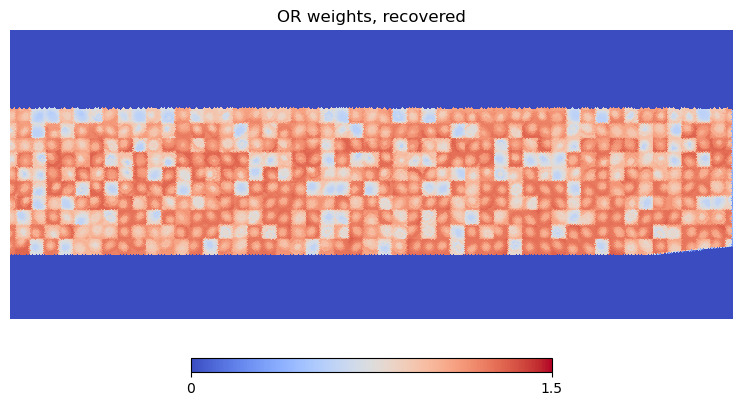

In [22]:
lonras=[0, 50]
latras=[-10,10]
delta_map_somor = wmap/(np.mean(wmap[np.nonzero(wmap)[0]]))-1
ms=hp.cartview(delta_map_somor+1, return_projected_map=True, lonra=lonras, latra=latras, max=1.5, title='OR weights, recovered',cmap='coolwarm')

In [23]:
lon_hp, lat_hp = hp.pix2ang(Ns_wmap, np.where(wmap>0)[0], lonlat=True)
tileind_hp = test_tiles.get_tileind(lon_hp, lat_hp)

keep_hp = np.ones(lon_hp.size)

for sys_name in sys_names:
    print(sys_name)
    
    _, depl_, _ = systematics[sys_name](lon_hp, lat_hp, tileind_hp, sys_depfuncs[sys_name], normed=True)
    keep_hp *= (1-depl_)

keep_map = np.zeros_like(wmap)
keep_map[np.where(wmap>0)[0]] = keep_hp
keep_map[np.isnan(keep_map)] = 0

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3851.48it/s]


sa
sb


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 8852.68it/s]


sc


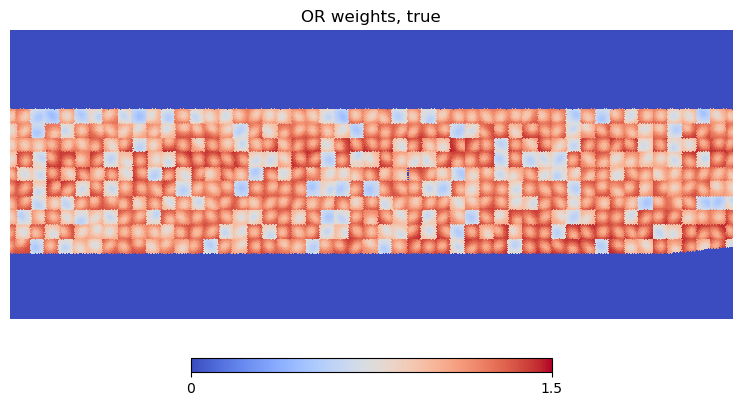

In [24]:
lonras=[0, 50]
latras=[-10,10]
delta_map_trueor = keep_map/(np.mean(keep_map[np.nonzero(wmap)[0]]))-1
ms=hp.cartview(delta_map_trueor+1, return_projected_map=True, lonra=lonras, latra=latras, max=1.5, title='OR weights, true',cmap='coolwarm')

# Calculate $w(\theta)$ with `treecorr`

## Use the reconstructed OR as random sample with depleted galaxy sample:

In [25]:
import treecorr
from treecorr_utils import *

nbins=30

catd_depleted = treecorr.Catalog(hpcat_depleted, ra_col="RA", dec_col="Dec", w_col='Delta', ra_units='deg', dec_units='deg', npatch=30)
catr_som_or = treecorr.Catalog(hpcat_orweight, ra_col="RA", dec_col="Dec", w_col='Delta', ra_units='deg', dec_units='deg', patch_centers=catd_depleted.patch_centers)
theta_som_hp_or , w_som_hp_or, cov_som_hp_or = treecorr_NNcor(catd_depleted, catr_som_or, nbins=20, max_sep=250, min_sep = 2.5, var_method='bootstrap')

## Use a uniform random sample with depleted galaxy sample:

In [26]:
catr_true_or = treecorr.Catalog(hpcat_trueOR, ra_col="RA", dec_col="Dec", w_col='Delta', ra_units='deg', dec_units='deg', patch_centers=catd_depleted.patch_centers)
catr_ur = treecorr.Catalog(hpcat_ur_unbiased, ra_col="RA", dec_col="Dec", w_col='Delta', ra_units='deg', dec_units='deg', patch_centers=catd_depleted.patch_centers)
theta_ur , w_ur, cov_ur = treecorr_NNcor(catd_depleted, catr_ur, nbins=20, max_sep=250, min_sep = 2.5, var_method='bootstrap')

## Use a depleted random sample (by the true OR) with depleted galaxy sample:

In [27]:
theta_true_or , w_true_or, cov_true_or = treecorr_NNcor(catd_depleted, catr_true_or, nbins=20, max_sep=250, min_sep = 2.5, var_method='bootstrap')

## Use a uniform random sample with uniformly depleted galaxy sample

In [28]:
catd_unbiased = treecorr.Catalog(hpcat_unbiased, ra_col="RA", dec_col="Dec", w_col='Delta', ra_units='deg', dec_units='deg', npatch=45)
catr_unbiased = treecorr.Catalog(hpcat_ur_unbiased, ra_col="RA", dec_col="Dec", w_col='Delta', ra_units='deg', dec_units='deg', patch_centers=catd_unbiased.patch_centers)
theta_unbiased, w_unbiased, cov_unbiased = treecorr_NNcor(catd_unbiased, catr_unbiased, nbins=20, max_sep=250, min_sep = 2.5, var_method='bootstrap')

# Calculate theoretical $w(\theta)$

In [30]:
import pyccl

cosmo_pyccl = pyccl.Cosmology(Omega_c=Oc, Omega_b=Ob, h=h, n_s=0.96, sigma8=sigma8)
gtracer = pyccl.NumberCountsTracer(cosmo_pyccl, has_rsd=False, dndz=(z, dndz), bias=(z, np.ones_like(z)))

ell = np.linspace(0, 2000, 200000)
cell = pyccl.angular_cl(cosmo_pyccl, gtracer, gtracer, ell)
w_theory = pyccl.correlation(cosmo_pyccl, ell, cell, theta_ur/60)

# Plot them!

In [31]:
def mask_arrays(array, mask):
    dim = array.ndim
    array_masked = array.copy()
    for i in range(dim):
        array_masked = np.delete(array_masked, mask, axis=i)
    return array_masked

In [32]:
mask = (theta_unbiased<20)

diff = mask_arrays(w_som_hp_or - w_true_or, mask)
cov = mask_arrays(cov_som_hp_or, mask)
chi2 = (diff @ np.linalg.inv(cov) @ diff) / diff.size

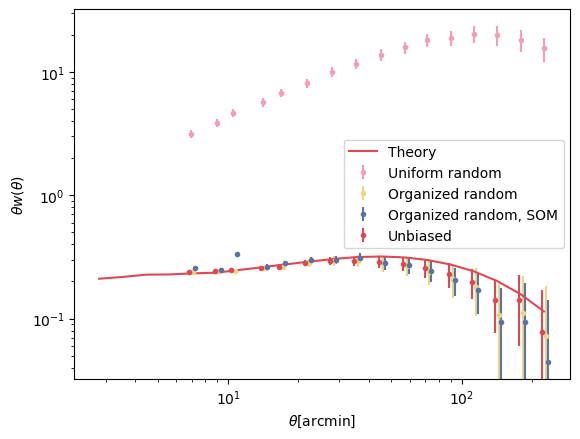

In [33]:
colors_btr = {'bocchi': '#f49db5',
              'nijika': '#ebd483',
              'ryo':'#5675a5',
              'kita':'#df4853',
              'black':'k'}

w_theory = pyccl.correlation(cosmo_pyccl, ell, cell, theta_ur/60)
plt.errorbar(theta_ur, theta_ur*w_ur, label='Uniform random', yerr=theta_ur * np.diag(cov_ur) ** 0.5, fmt='.', color=colors_btr['bocchi'])
plt.errorbar(theta_true_or*1.02, theta_true_or*w_true_or, label='Organized random', yerr=theta_true_or * np.diag(cov_true_or) ** 0.5, fmt='.', color=colors_btr['nijika'])
plt.errorbar(theta_som_hp_or*1.04, theta_som_hp_or*w_som_hp_or, label='Organized random, SOM', yerr=theta_som_hp_or * np.diag(cov_som_hp_or) ** 0.5, fmt='.', color=colors_btr['ryo'])
plt.errorbar(theta_unbiased*0.98, theta_unbiased*w_unbiased, label='Unbiased', yerr=theta_unbiased * np.diag(cov_unbiased) ** 0.5, fmt='.', color=colors_btr['kita'])
plt.xscale('log')
plt.semilogx(theta_ur, theta_ur*w_theory, label='Theory', color=colors_btr['kita'])
plt.legend()
plt.xlabel(r'$\theta$[arcmin]')
plt.ylabel(r'$\theta w(\theta)$')
plt.yscale('log')
#plt.axvline(pixscale*2**0.5, 0, 1, color='k')
#plt.ylim(0.01, 1)

/tmp/ipykernel_2997706/2797014454.py:11: RuntimeWarning: invalid value encountered in divide
  plt.errorbar(theta_true_or*1.02, w_true_or/w_unbiased, label='Organized random', yerr=np.diag(cov_true_or) ** 0.5/w_unbiased, fmt='.', color=colors_btr['nijika'])
/tmp/ipykernel_2997706/2797014454.py:12: RuntimeWarning: invalid value encountered in divide
  plt.errorbar(theta_som_hp_or*1.04, w_som_hp_or/w_unbiased, label='Organized random, SOM', yerr=np.diag(cov_som_hp_or) ** 0.5/w_unbiased, fmt='.', color=colors_btr['ryo'])
/tmp/ipykernel_2997706/2797014454.py:13: RuntimeWarning: invalid value encountered in divide
  plt.errorbar(theta_unbiased*0.98, w_unbiased/w_unbiased, label='Unbiased', yerr=np.diag(cov_unbiased) ** 0.5/w_unbiased, fmt='.', color=colors_btr['kita'])


(0.0, 2.0)

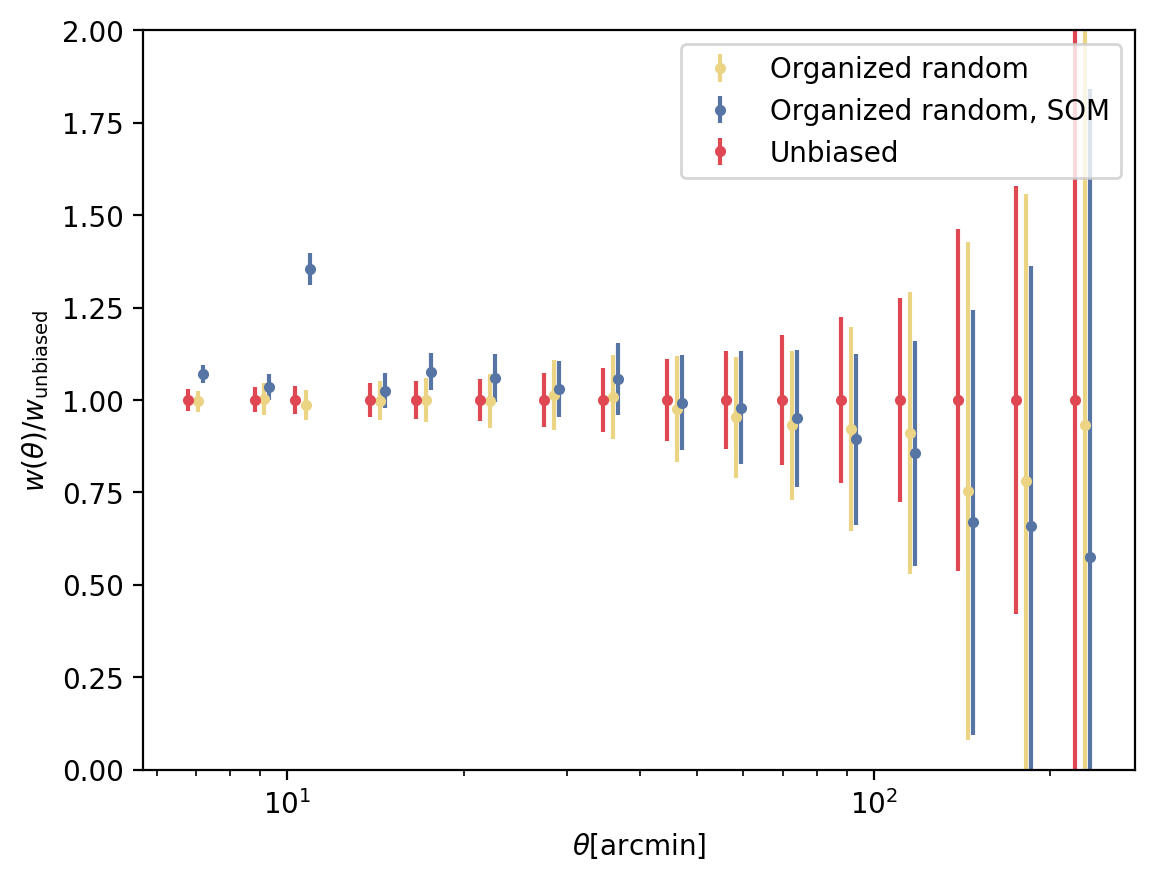

In [34]:
colors_btr = {'bocchi': '#f49db5',
              'nijika': '#ebd483',
              'ryo':'#5675a5',
              'kita':'#df4853',
              'black':'k'}

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200
w_theory = pyccl.correlation(cosmo_pyccl, ell, cell, theta_ur/60)
#plt.errorbar(theta_ur, theta_ur/w_unbiased, label='Uniform random', yerr=np.diag(cov_ur) ** 0.5/w_unbiased, fmt='.', color=colors_btr['bocchi'])
plt.errorbar(theta_true_or*1.02, w_true_or/w_unbiased, label='Organized random', yerr=np.diag(cov_true_or) ** 0.5/w_unbiased, fmt='.', color=colors_btr['nijika'])
plt.errorbar(theta_som_hp_or*1.04, w_som_hp_or/w_unbiased, label='Organized random, SOM', yerr=np.diag(cov_som_hp_or) ** 0.5/w_unbiased, fmt='.', color=colors_btr['ryo'])
plt.errorbar(theta_unbiased*0.98, w_unbiased/w_unbiased, label='Unbiased', yerr=np.diag(cov_unbiased) ** 0.5/w_unbiased, fmt='.', color=colors_btr['kita'])
plt.xscale('log')
#plt.semilogx(theta_ur, theta_ur*w_theory, label='Theory', color=colors_btr['kita'])
plt.legend()
plt.xlabel(r'$\theta$[arcmin]')
plt.ylabel(r'$w(\theta)/w_{\mathrm{unbiased}}$')
#plt.yscale('log')
#plt.axvline(pixscale*2**0.5, 0, 1, color='k')
plt.ylim(0, 2)

## also plot the standard deviations

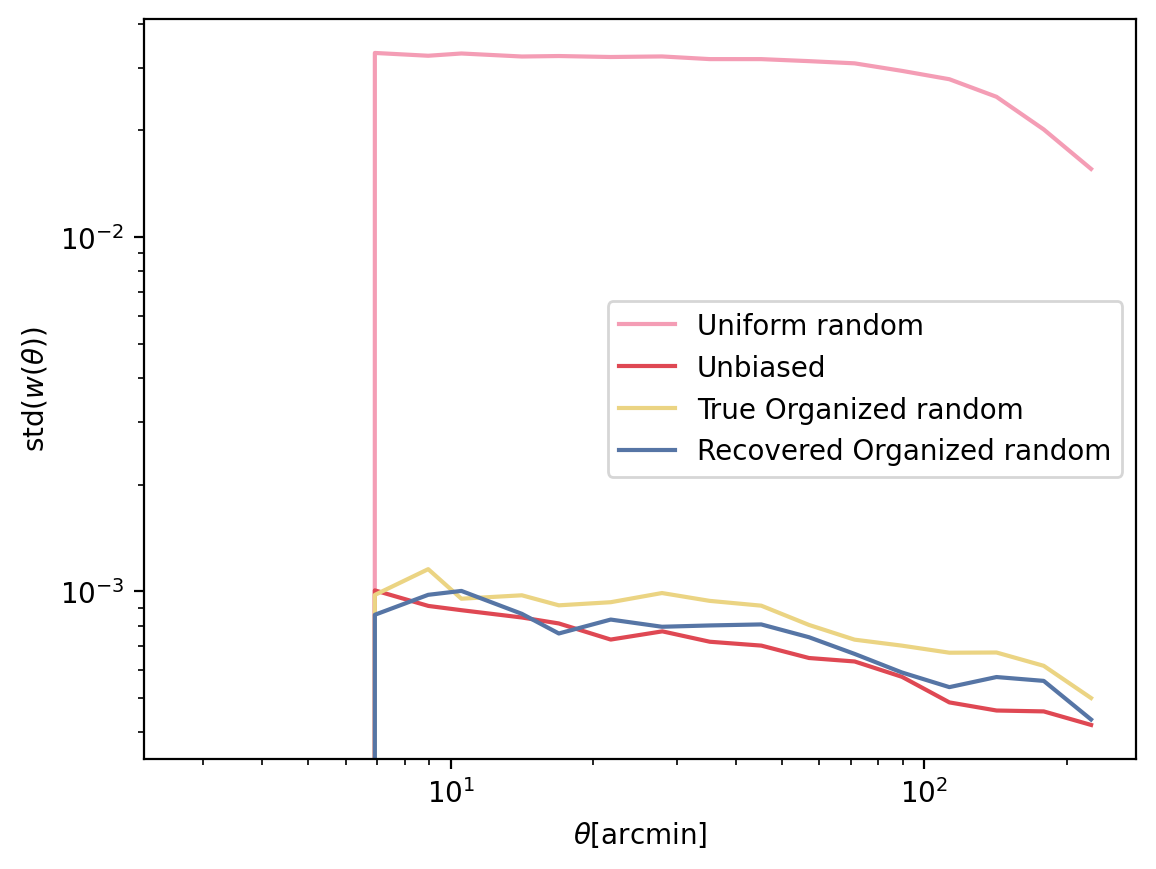

In [35]:
colors_btr = {'bocchi': '#f49db5',
              'nijika': '#ebd483',
              'ryo':'#5675a5',
              'kita':'#df4853',
              'black':'k'}

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200
w_theory = pyccl.correlation(cosmo_pyccl, ell, cell, theta_ur/60)
plt.plot(theta_ur, np.diag(cov_ur) ** 0.5, label='Uniform random', color=colors_btr['bocchi'])
plt.plot(theta_unbiased, np.diag(cov_unbiased) ** 0.5, label='Unbiased', color=colors_btr['kita'])
plt.plot(theta_true_or, np.diag(cov_true_or) ** 0.5, label='True Organized random', color=colors_btr['nijika'])
plt.plot(theta_som_hp_or, np.diag(cov_som_hp_or) ** 0.5, label='Recovered Organized random', color=colors_btr['ryo'])
plt.legend()
plt.xlabel(r'$\theta$[arcmin]')
plt.ylabel(r'std$(w(\theta))$')
plt.yscale('log')
plt.xscale('log')